In [ ]:
!pip install corextopic
!pip install joblib

In [ ]:
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import pandas as pd
import json

from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [ ]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16_.json')
datafile = json.load(f)
df = pd.json_normalize(datafile)

In [ ]:
df.head()
df.shape

(78313, 22)

In [ ]:
#Converting the DF to list to feed to the CorEx Model
dfToList = df['_source.complaint_what_happened'].tolist()

dfList = list(df['_source.complaint_what_happened'])

dfValues = df['_source.complaint_what_happened'].values
#print(dfList)
print(dfValues)

[''
 'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'
 'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX   changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.'
 ...
 'I am not familiar with XXXX pay and did not understand the great risk this provides to consumers. I believed this to be safe as it was t

In [ ]:
# Transform data into a sparse matrix
vectorizer = CountVectorizer(stop_words='english', max_features=20000,binary = True)
doc_word = vectorizer.fit_transform(df['_source.complaint_what_happened'].values.astype('U')) #Learn the vocabulary dictionary and return term-document matrix.
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(78313, 20000)

In [ ]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names_out()))

In [ ]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(78313, 19348)

In [ ]:
# Train the CorEx topic model with 10 topics
topic_model = ct.Corex(n_hidden=10, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [ ]:
# Print a single topic from CorEx topic model.
topic_model.get_topics(topic=7, n_words=10)

[('stated', 0.0659901408692115, 1.0),
 ('fact', 0.050403977765823914, 1.0),
 ('point', 0.041148271720763054, 1.0),
 ('finally', 0.038740416047334844, 1.0),
 ('customers', 0.03505651897528119, 1.0),
 ('second', 0.03427467287508936, 1.0),
 ('based', 0.030757748630291668, 1.0),
 ('clearly', 0.029795011199233338, 1.0),
 ('dated', 0.025833687560958444, 1.0),
 ('actually', 0.02502178831490289, 1.0)]

In [ ]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: chase,xxxx,account,credit,xx,bank,card,did,received,time
1: told,called,said,phone,asked,customer,went,day,just,know
2: issue,contact,dispute,request,requested,filed,immediately,file,fraudulent,response
3: department,person,work,office,needed,deposit,situation,hold,ask,left
4: funds,transaction,branch,email,online,claim,manager,returned,debit,deposited
5: rate,terms,including,period,agreement,note,practices,entire,high,simply
6: loan,mortgage,home,property,foreclosure,modification,house,sale,attorney,insurance
7: stated,fact,point,finally,customers,second,based,clearly,dated,actually
8: financial,required,legal,law,review,prior,action,act,issues,writing
9: make,business,right,good,making,consumer,having,doing,wrong,came


In [ ]:
topic_model.get_topics(topic=5, n_words=10, print_words=False)

[(10835, 0.03710076190947411, 1.0),
 (15708, 0.02760626195006515, 1.0),
 (6839, 0.02746451063217111, 1.0),
 (9638, 0.02646021476766345, 1.0),
 (566, 0.024980102960259626, 1.0),
 (8933, 0.022924764959770735, 1.0),
 (10016, 0.021175227045123934, 1.0),
 (4784, 0.020408556630848517, 1.0),
 (6404, 0.020121042733547524, 1.0),
 (13778, 0.018266571733688536, 1.0)]

In [ ]:
print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words

[6 4 4 ... 1 5 5]
(19348,)


In [ ]:
# Print a single topic from CorEx topic model
topic_model.get_top_docs(topic=7, n_docs=10, sort_by='log_prob')

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(61493, 0.0),
 (57775, 0.0),
 (48830, 0.0),
 (16381, 0.0),
 (71542, 0.0),
 (24938, 0.0),
 (24941, 0.0),
 (48826, 0.0),
 (3449, 0.0),
 (24955, 0.0)]

In [ ]:
print(topic_model.p_y_given_x.shape) # n_docs x k_topics

(78313, 10)


In [ ]:
print(topic_model.labels.shape) # n_docs x k_topics

(78313, 10)


In [ ]:
#Total correlation is the measure which CorEx maximize when constructing the topic model. It can be accessed through tc and is reported in nats.
topic_model.tc

22.870848708006505

In [ ]:
topic_model.tcs.shape # k_topics

(10,)

In [ ]:
print(np.sum(topic_model.tcs))
print(topic_model.tc)

22.870848708006505
22.870848708006505


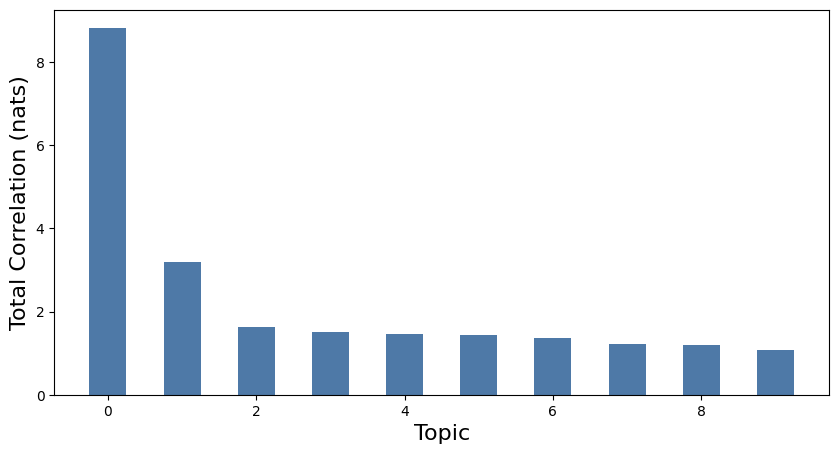

In [ ]:
#Selecting number of topics:Choosing from the data visualised
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('Distribution of TCs for each topic', dpi=600)

In [ ]:
topic_model.log_z.shape # n_docs x k_topics

(78313, 10)

In [ ]:
print(np.mean(topic_model.log_z, axis=0)) #The pointwise total correlations in log_z represent the correlations within an individual document explained by a particular topic. These correlations have been used to measure how "surprising" documents are with respect to given topics
print(topic_model.tcs)

[8.82117065 3.18545835 1.62612813 1.50262979 1.44887643 1.43554118
 1.35268617 1.21874688 1.20458043 1.07503069]
[8.82117065 3.18545835 1.62612813 1.50262979 1.44887643 1.43554118
 1.35268617 1.21874688 1.20458043 1.07503069]


In [ ]:
# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);

In [ ]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=words, max_edges=200, prefix='topic-model-example')

weight threshold is 0.000000 for graph with max of 110.000000 edges 


In [ ]:
!pip install tqdm

In [ ]:
## defining all utilty functions - needed for Data cleaning and processing

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text):
    pattern = r"(?u)\b\w\w+\b"
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text):
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [ ]:
# Get the word count
df['word_count'] = df['_source.complaint_what_happened'].apply(word_count)
df['word_count'].mean()

69.0738191615696

In [ ]:
# Process the text
df['processed_text'] = df['_source.complaint_what_happened'].apply(process_text)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided,word_count,processed_text
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided,1,[]
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,92,"[good, morn, xxxx, xxxx, appreci, help, stop, ..."
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,65,"[upgrad, xxxx, xxxx, card, xx, xx, told, agent..."
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided,1,[]
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A,1,[]


In [ ]:
!pip install tqdm
!pip install stylegan2_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.4 MB/s eta

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
from tqdm import tqdm as tqdm

# Use Gensim's CorEX to get the best num of topics via coherence score
texts = df['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Creating corpus using dictionary prepared above
corpus = [dictionary.doc2bow(doc) for doc in tqdm(texts)]

# Get top words for each topic from the trained corex model
topics = topic_model.get_topics(n_words=100)
corex_topic_words = [[word for word, tc,_ in topic] for topic in topics]

100%|██████████| 78313/78313 [00:01<00:00, 41143.77it/s]


In [ ]:
topics

[[('chase', 0.6074052133397961, 1.0),
  ('xxxx', 0.606972488273027, 1.0),
  ('account', 0.3485668860713481, 1.0),
  ('credit', 0.3008663292960474, 1.0),
  ('xx', 0.2941149788356457, 1.0),
  ('bank', 0.2758583975118626, 1.0),
  ('card', 0.24512652448784422, 1.0),
  ('did', 0.2314466075259568, 1.0),
  ('received', 0.19379308860596606, 1.0),
  ('time', 0.18844124069456528, 1.0),
  ('money', 0.14128751239574286, 1.0),
  ('payment', 0.134815442468539, 1.0),
  ('information', 0.12992146713574326, 1.0),
  ('sent', 0.1296197808309335, 1.0),
  ('pay', 0.11992180984231289, 1.0),
  ('days', 0.1178599634529125, 1.0),
  ('letter', 0.10681765488747717, 1.0),
  ('number', 0.1066321904697612, 1.0),
  ('paid', 0.10502676772044094, 1.0),
  ('report', 0.10332044652951425, 1.0),
  ('closed', 0.09660072127482167, 1.0),
  ('help', 0.09524644323542954, 1.0),
  ('company', 0.09148347721274089, 1.0),
  ('years', 0.09036072717279925, 1.0),
  ('new', 0.08850627785149232, 1.0),
  ('payments', 0.08824022232941033,

In [ ]:
# Get coherence score
c_v_cm_corex = CoherenceModel(topics=corex_topic_words, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v')
c_v_cm_corex.get_coherence()

0.4043841528097378

In [ ]:
# Get coherence score
u_mass_cm_corex = CoherenceModel(topics=corex_topic_words, texts=texts, corpus=corpus, dictionary=dictionary, coherence='u_mass')
u_mass_cm_corex.get_coherence()

-2.467365338613526

In [ ]:
# Get coherence score
c_uci_cm_corex = CoherenceModel(topics=corex_topic_words, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_uci')
c_uci_cm_corex.get_coherence()

-0.21512798629177698

In [ ]:
# Get coherence score
c_npmi_cm_corex = CoherenceModel(topics=corex_topic_words, texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_npmi')
c_npmi_cm_corex.get_coherence()

0.0054825905980013965